In [ ]:
#bibliotecas
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from matplotlib import pyplot as plt

### Pre-processamento

In [ ]:
# Lendo dados;
data = pd.read_csv("../Databases/poluicao.csv")

# Apagando colunas que não serão necessarias;
data = data.drop(["No" , "year" , "month" , "day" , "hour", "cbwd"], axis=1)

# Retirando valoes vazios;
data = data.dropna()

train = data.iloc[:, 1:8]
label = data.iloc[:, 0:1]

del data
# Preparando para normalizar o y_train;
normalizador_train = MinMaxScaler(feature_range=(0,1))
norm_train = normalizador_train.fit_transform(train)

norm_label = normalizador_train.fit_transform(label)

In [ ]:
# Preparando, será usado 90;
train_pred = []
real_label = []

for i in range(10, train.shape[0]):
    train_pred.append(norm_train[i-10:i, 0:6])
    real_label.append(norm_label[i, 0])

pred, real = np.array(train_pred), np.array(real_label)

del train_pred, real_label

### Criando camadas da rede neural

In [ ]:
def createNetwork():
    model = Sequential()
    # camada de entrada
    model.add(LSTM(units=100, return_sequences=True, input_shape = (pred.shape[1], 6)))
    model.add(Dropout(0.3))
    # Camada oculta 01;
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.3))

    # Camada oculta 02;
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.3))

    # Camada oculta 03;
    model.add(LSTM(units=50))
    model.add(Dropout(0.3))

    # Camada de saída;
    model.add(Dense(units=1, activation='sigmoid'))

    # Configurando compile;
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])

    return model

In [ ]:
# Definindo callbacks;
es = EarlyStopping(monitor="loss", # O que ele irá monitorar;
                min_delta=1e-10, # minimo de melhora;
                patience=10, # Quantidade de epocas que espera antes de parar;
                verbose=1) # Mostrar mensagens;

rlr = ReduceLROnPlateau(monitor="loss", # O que ele monitora;
                    factor=0.2, # Fator de diminuição da taxa de aprendizagem;
                    patience=5, # Quantas epocas ele espera antes de diminuir a taxa de aprendozagem;
                    verbose=1) # Mostrar mensagens;

mcp = ModelCheckpoint(monitor="loss", # O que monitora;
                    filepath="pesos.h5", # Onde salvar os pessos;
                    save_best_only=True) # Habilita para salvas os pesos;

# Criando rede neural;
regressor = createNetwork()
# Treinando modelo
regressor.fit(pred, real, epochs=100, batch_size= 64, callbacks= [es,rlr,mcp])

### Trabalhando com dados de teste

In [ ]:
# Realizando previões;
pred = regressor.predict(pred)
# Fazendo a normalização iversa;
pred_test = normalizador_train.inverse_transform(pred)

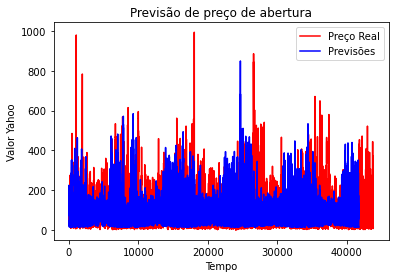

In [8]:
# Criando Grafico;
plt.figure()
plt.plot(label, color="red", label="Preço Real" )
plt.plot(pred_test, color="blue", label="Previsões")
plt.title("Previsão de preço de abertura")
plt.xlabel("Tempo")
plt.ylabel("Valor Yahoo")
plt.legend()
plt.show();